<a href="https://colab.research.google.com/github/dzagar/titanic-disaster-ml/blob/master/swhela2_dzagar_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Titanic Disaster
Sarah Whelan, Dana Zagar

***The problem we are modelling is the Titanic disaster, and the likelihood of survival depending on various features described in passenger data. We will be using the Naive Bayes classifier and the Multi-Layer Perceptron classifier as well as classic data cleaning techniques to achieve an acceptance rate of approximately 79% on the Kaggle test set.***

Setting up the environment with required imports.

In [0]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from IPython.display import display

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



Adding confusion matrix display awesomeness, for looking at our model predictiveness scores later.

In [0]:
def display_confusion_matrix(desired, predicted, score=None):
  conMat = metrics.confusion_matrix(desired, predicted)
  plt.figure(figsize=(6,6))
  sb.heatmap(conMat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  if score:
    score_title = 'Accuracy: {0}'.format(round(score, 5))
    plt.title(score_title, size=13)
  class_report = pd.DataFrame.from_dict(metrics.classification_report(desired, predicted, output_dict=True), orient='index')
  display(class_report.round(2))

Retrieving and loading the data (just copied data to local runtime).

In [0]:
# Get data files
training_set = "/content/train.csv"
testing_set = "/content/test.csv"

In [0]:
# Use Pandas to create a data frame
training_df = pd.read_csv(training_set)
testing_df = pd.read_csv(testing_set)
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
# Show stats on each attribute in the data set
training_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's get numerical recurrences of attributes in the data frame so we can see if we are missing any data points at a quick glance.

In [0]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


What data is consistent? Which attributes provide smaller data sets?

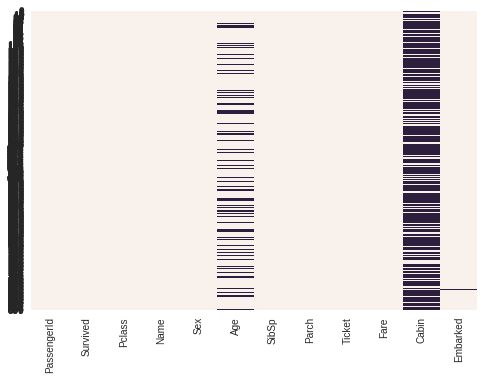

In [0]:
sb.heatmap(training_df.isnull(), cbar=False)

From the output we can see, it looks like the Cabin attribute defines a much smaller data set. Age is also sparse. We won't use Cabin at face value, but we can massage the data later in feature engineering. For age, we could group the data by other features and find the average for its corresponding category. Embarked is also missing two values.

First, let's try to find the most likely Embarked values for these data points given the fare value and the sex:

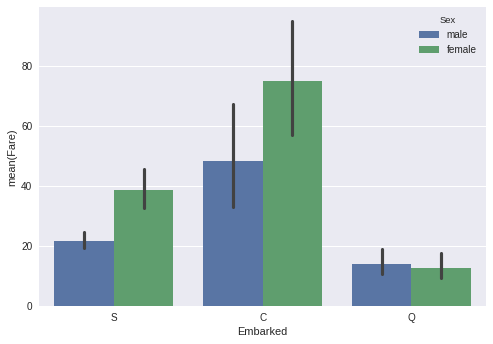

In [0]:
pl = sb.barplot(x="Embarked", y="Fare", hue="Sex", data=training_df)

Let's look at the two data points missing their Embarked value, and see if we can match them up to our findings in the graph.

In [0]:
training_df[training_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Both passengers are female and both paid 80 dollars for their fare. A solid best guess would be that they embarked from C since the average fare for females embarking from C was closest to 80 dollars.

Visualizing each attribute in the training data to make some initial observations:

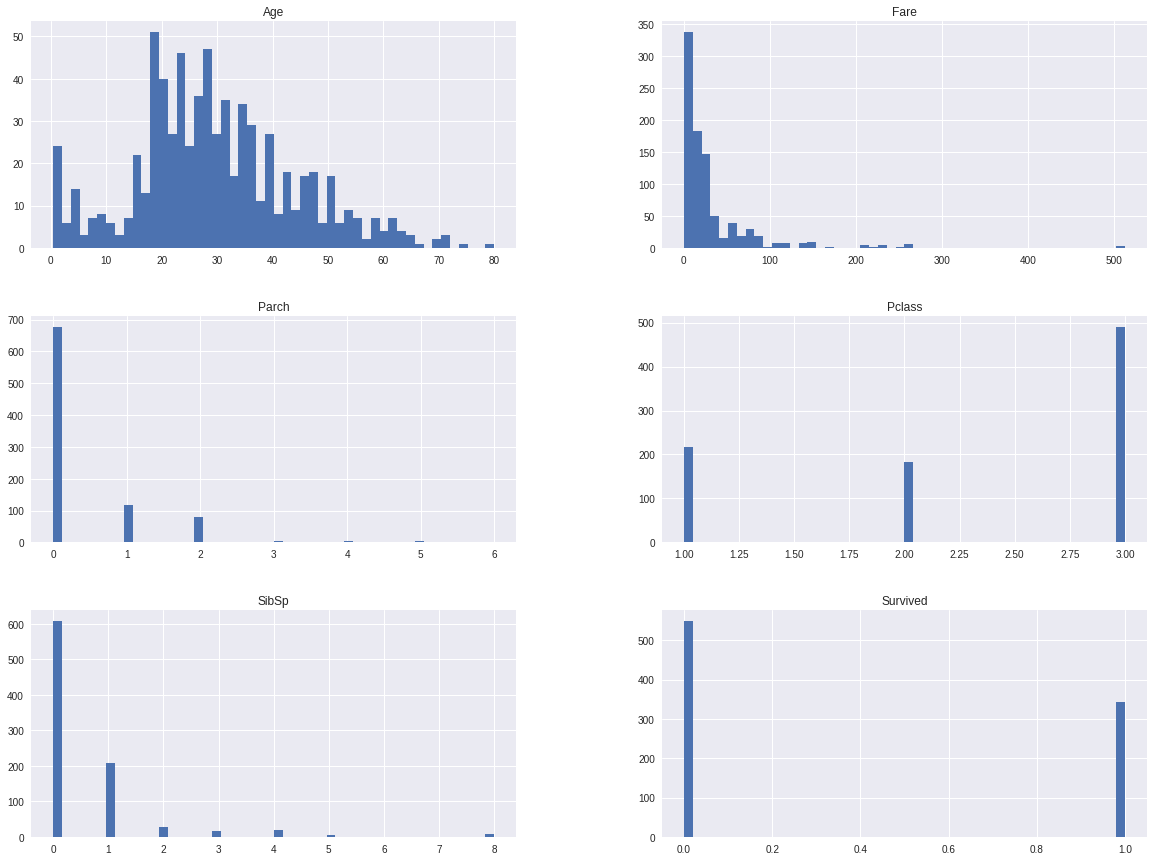

In [0]:
training_df.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

Observations:
- Most passengers were between the ages of 20-40. (Ages)
- An overwhelming amount of passengers paid the lowest fare range (between 0 and 10 dollars) and the majority paid under 50 dollars. (Fare)
- Only around 38% of passengers actually survived. (Survived)
- Over 50% of passengers were the lowest social class. (Pclass)
- Many passengers were travelling alone. (SibSp, Parch)

Noticing that Sex has not been plotted, let's plot them against the survival rate to see if we can see a trend.

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924


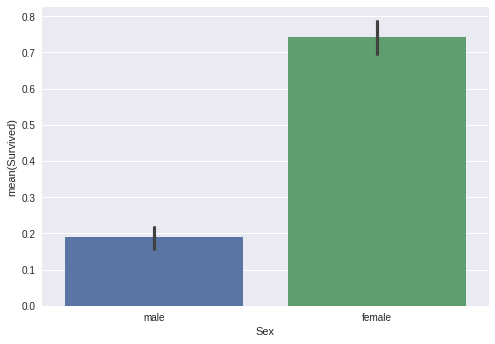

In [0]:
# Bar plot of Survival by Sex
sb.barplot(x="Sex", y="Survived", data=training_df)

# Print percentages of females vs. males that survived.
print("Percentage of females who survived:", training_df["Survived"][training_df["Sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Percentage of males who survived:", training_df["Survived"][training_df["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

This displays a huge trend - females were much more likely to survive. Therefore, keeping Sex in our model is critical.

Now, the next feature that was interesting is Class, since the majority of the people on the ship were in the third and lowest class. Let's plot this against survival.

Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


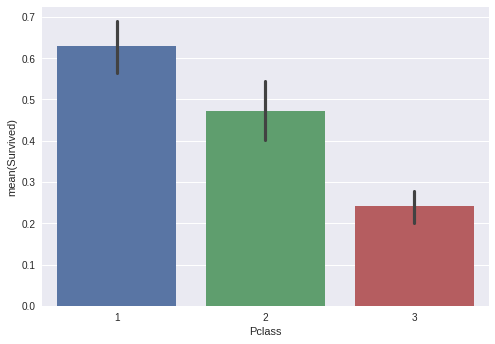

In [0]:
# Bar plot of Survival by Pclass
sb.barplot(x="Pclass", y="Survived", data=training_df)

# Print percentage of people by Pclass that survived.
print("Percentage of Pclass = 1 who survived:", training_df["Survived"][training_df["Pclass"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of Pclass = 2 who survived:", training_df["Survived"][training_df["Pclass"] == 2].value_counts(normalize = True)[1]*100)
print("Percentage of Pclass = 3 who survived:", training_df["Survived"][training_df["Pclass"] == 3].value_counts(normalize = True)[1]*100)

From the graph, we can see that the higher your socioeconomic status, the more likely you were to survive, as less than 25% of people in the third class survived. As such, we will definitely use Pclass in our model.

The next feature we wanted to investigate was Age. Since many Age values are missing from the dataset, we'll just quickly fill in the gaps with Unknown and then plot Age against Survival to see if we can find a trend.

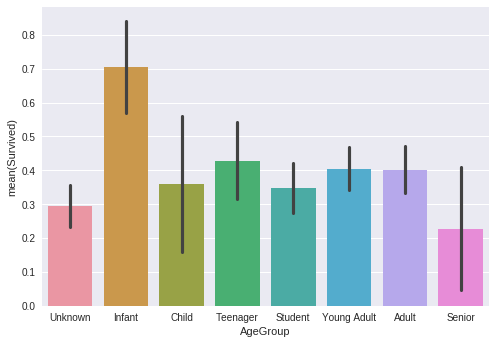

In [0]:
def sort_age_group(df_raw):  
  df = df_raw.copy()
  # Sort the ages into logical categories
  df["Age"] = df["Age"].fillna(-0.5)
  bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
  labels = ['Unknown', 'Infant', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
  df['AgeGroup'] = pd.cut(df["Age"], bins, labels = labels)
  return df

# Bar plot of Age vs. Survival
sb.barplot(x="AgeGroup", y="Survived", data=sort_age_group(training_df))
plt.show()

It is very clear from the graph that you were much more likely to survive if you were an Infant. Age will be extremely important in our prediction model, so we will need to fill in the gaps in this data as well as we can.

One feature that was not plotted initially was Cabin. Because of the inconsistency in the recorded cabin numbers for passengers who did have them, we wanted to investigate and see if there were any correlations between just having a cabin vs not and survival.

Percentage of HasCabin = 1 who survived: 66.66666666666666
Percentage of HasCabin = 0 who survived: 29.985443959243085


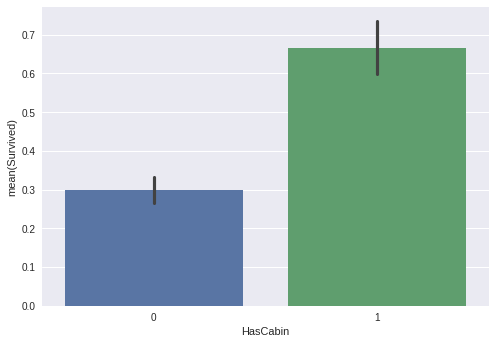

In [0]:
def extract_has_cabin(df_raw):
  df = df_raw.copy()
  df["HasCabin"] = (df["Cabin"].notnull().astype('int'))
  return df

# Calculate percentages of HasCabin vs Survived
print("Percentage of HasCabin = 1 who survived:", training_df["Survived"][extract_has_cabin(training_df)["HasCabin"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of HasCabin = 0 who survived:", training_df["Survived"][extract_has_cabin(training_df)["HasCabin"] == 0].value_counts(normalize = True)[1]*100)

# Bar plot of HasCabin vs Survival
sb.barplot(x="HasCabin", y="Survived", data=extract_has_cabin(training_df))
plt.show()

We can infer from the graph that if a passenger did have a cabin, their survival was much more likely. Digging deeper, let's strip out the level of the cabin (first character) and see if that gives us any clues.

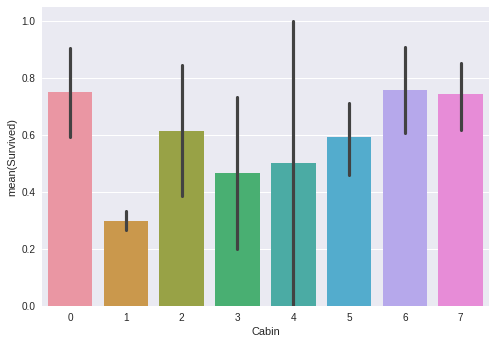

In [0]:
def strip_cabin_level(df_raw):
  df = df_raw.copy()
  df['Cabin'].fillna('X', inplace=True)
  df['Cabin'][df['Cabin'] == 'T'] = 'X' # get rid of T class
  # Strip Cabin level
  df['Cabin'] = df['Cabin'].str[:1]
  df['Cabin'] = df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in df['Cabin']))})
  return df
# Bar plot Cabin vs Survival
#stripCabinLevel(training_df).head(25)
sb.barplot(x="Cabin", y="Survived", data=strip_cabin_level(training_df))
plt.show()

As we can see, people with rooms on the second, fourth and fifth levels were more likely to survive. 
* Note that this is assigning arbitrary enum values to each class, so the graph will change on reload. However, it can be deduced by looking at the dataframe that not having a cabin is the lowest survival rate, and the second, fourth and fifth levels are the highest.

Now, let's fill in the Embarked values with our best guess from earlier.

In [0]:
def fill_in_missing_embarked(df_raw):
  df = df_raw.copy()
  # Fill in two values for Embarked
  # Determined before to use 'C'
  df['Embarked'].fillna('C', inplace=True)
  return df

Next item is to predict the Age values that are missing, which is critical in the accuracy of our model. To do so, we will extract a new feature "Title" which will help us to determine which age the passengers are. This feature will likely help us to further fine tune the likelihood of passenger survival as well, adding further granularity to Sex and Pclass.

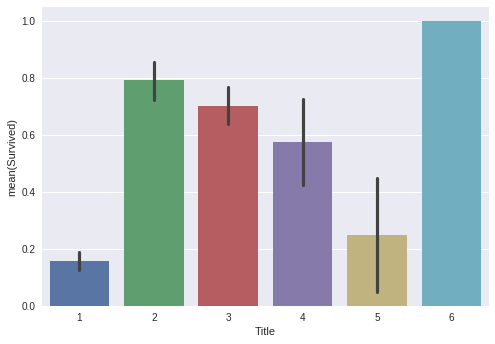

In [0]:
def extract_title(df_raw):
  df = df_raw.copy()
  # Create honoristics column (Title), using the Name column.
  df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in df['Name']), index=df.index)
  df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
  df['Title'] = df['Title'].replace('Mme', 'Mrs')
  df['Title'] = df['Title'].replace(['Rev', 'Jonkheer', 'Dr', 'Capt', 'Col', 'Don', 'Dona', 'Major'], 'Unique')
  df['Title'] = df['Title'].replace(['the Countess','Sir', 'Countess', 'Lady'], 'Royal')
  df['Title'] = df['Title'].map({
      "Mr": 1,
      "Mrs": 2,
      "Miss": 3,
      "Master": 4,
      "Unique": 5,
      "Royal" : 6,
  })
  return df

# Bar plot of Title vs Survival
sb.barplot(x="Title", y="Survived", data=extract_title(training_df))
plt.show()

From the graph we can see that people with the Mr. title were unlikely to survive, and that people with Royal titles are <b>nearly guaranteed</b> to survive with a 100% survival rate. This is extremely important for our model.

Now, let's predict Age Group using the mode value of the corresponding Title.

In [0]:
# [pre] Just used this to figure out the mappings for each age group (age_title_mapping)
def print_mode_age_per_title(df_train):
  df = df_train.copy()
  # Fill missing age with mode age group for each title
  mr_age = df[df["Title"] == 1]["AgeGroup"].mode() # Young adult
  mrs_age = df[df["Title"] == 2]["AgeGroup"].mode() # Adult
  miss_age = df[df["Title"] == 3]["AgeGroup"].mode() # Student
  master_age = df[df["Title"] == 4]["AgeGroup"].mode() # Infant
  unique_age = df[df["Title"] == 5]["AgeGroup"].mode() # Adult
  royal_age = df[df["Title"] == 6]["AgeGroup"].mode() # Adult

  
def predict_missing_age_group(df_raw):
  df = df_raw.copy()

  age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Infant", 5: "Adult", 6: "Adult"}

  for x in range(len(df["AgeGroup"])):
      if df["AgeGroup"][x] == "Unknown":
          df["AgeGroup"][x] = age_title_mapping[df["Title"][x]]
          
  # Map to numeric values
  age_mapping = {'Infant': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
  df['AgeGroup'] = df['AgeGroup'].map(age_mapping)
  
  return df

An interesting feature could be family sizes, and how that impacted survival.

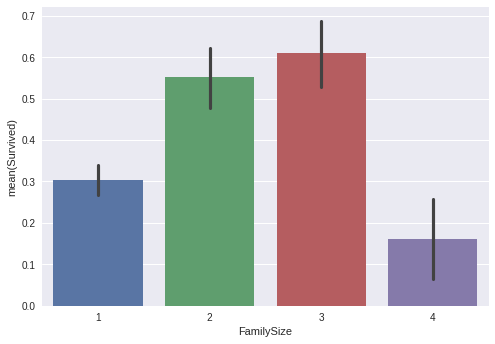

In [0]:
def extract_family_size(df_raw):
  df = df_raw.copy()
  # Create family size feature; sum of SibSp, Parch + 1 (to add person in question).
  # Map: alone if family size is 1; duo if 2; 3-4 members if 3; 5+ members if 4
  df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
  df['FamilySize'][df['FamilySize'].between(2, 5, inclusive=False)] = 3
  df['FamilySize'][df['FamilySize'] >= 5] = 4
  return df

# Bar plot of FamilySize vs Survival
sb.barplot(x="FamilySize", y="Survived", data=extract_family_size(training_df))
plt.show()

Interesting results here. One was less likely to survive if they were alone, or in a group of five or more people, but more likely to survive if they were in a couple or a small family group. This data point could likely be made more specific with more analysis (extended family, etc.) but we will leave it as is for now.

Another interesting find when reviewing the test data was that people could have the same ticket number if they were traveling with a nanny or something similar. We could look at the survival rate of those who had a repeated ticket number and the counterpart survived.

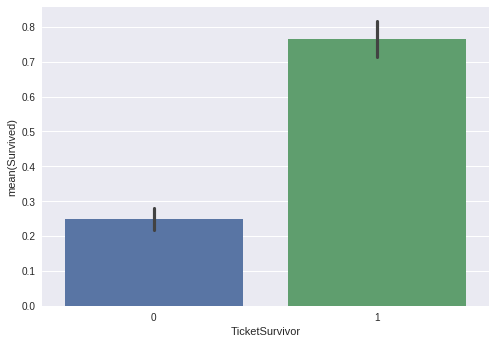

In [0]:
def extract_if_duplicate_survived(df_raw):
  df = df_raw.copy()
  # Add a column indicating if another passenger with the same ticket number survived (nanny, etc.).
  df['TicketSurvivor'] = pd.Series(0, index=df.index)
  tickets = df['Ticket'].value_counts().to_dict()
  for t, occ in tickets.items():
    if occ != 1:
      table = training_df['Survived'][training_df['Ticket'] == t]
      if sum(table) != 0:
        df['TicketSurvivor'][df['Ticket'] == t] = 1
  return df

sb.barplot(x="TicketSurvivor", y="Survived", data=extract_if_duplicate_survived(training_df))
plt.show()

Interesting again; if someone had a counterpart ticket holder that survived, they were much more likely to survive.

To fill in our missing Fare values in the test set, we will just interpolate based on the training data.

In [0]:
def fill_in_missing_fare(df_raw):
  df = df_raw.copy()
  df["Fare"] = df_raw["Fare"].interpolate()
  return df

Feature engineering time!

In our preprocessing, we can make a couple adjustments.
- We want to fill in the two values for Embarked that we made a best guess for earlier.
- We want to fill in the missing cabin values with a filler value 'X' instead of null.
- There is a missing data point for Fare in the test data set; we can interpolate this value.

After making these adjustments, we can perform some feature engineering on the columns.
- We can parse out a honorifics column using the values in the name column and run analyses on the prefixed title people had.
- We can create a family size column based on sibling/spouse and parent/child listings.
- We can create an is child column based on age.
- We can create an is alone column based on family size.
- We can strip out additional information from Cabin so it only includes the letter describing the deck of the boat.
- We can create a has cabin column based on cabin letter.
- We can create an age group column based on ages and predict the missing ages based on the mode of the title category.
- We can map Sex and Embarked to numerical values.

In [0]:
def preprocess(df):
  df_processed = df
  
  # First, filling in any missing values in the data set.
  df_processed = fill_in_missing_embarked(df_processed)
  df_processed = fill_in_missing_fare(df_processed)
  
  # Feature engineering on the Cabin value.
  df_processed = extract_has_cabin(df_processed)
  df_processed = strip_cabin_level(df_processed)
  
  # Creating the Title feature.
  df_processed = extract_title(df_processed)
  
  # Creating the AgeGroup feature and filling in missing age values.
  df_processed = sort_age_group(df_processed)
  df_processed = predict_missing_age_group(df_processed)
  
  # Creating the FamilySize feature.
  df_processed = extract_family_size(df_processed)
  
  # Creating the TicketSurvivor feature.
  df_processed = extract_if_duplicate_survived(df_processed)
  
  
  # Create is child feature
  df_processed['Child'] = np.where(df_processed['Age'] >= 18, 0, 1)
  
  # Create alone feature
  df_processed['Alone'] = np.where(df_processed['FamilySize'] != 1, 0, 1)
  
  # Drop columns we no longer need.
  df_processed.drop(['Name', 'Age', 'Ticket', 'PassengerId'], axis=1, inplace=True)
  
  # Map current features to numeric values
  df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1})
  df_processed['Embarked'] = df_processed['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
  
  return df_processed
  

In [0]:
# Divide training set into two sets for model eval
training_df_real = training_df.copy()
x = training_df_real.drop(['Survived'], 1)
y = training_df_real['Survived']

# Preprocess training inputs
x = preprocess(x)

# Scale data
scale = StandardScaler()
x = pd.DataFrame(scale.fit_transform(x.values), index=x.index, columns=x.columns)

# Split our inputs and output data for testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,HasCabin,Title,AgeGroup,FamilySize,TicketSurvivor,Child,Alone
331,-1.566107,-0.737695,-0.474545,-0.473674,-0.074583,1.735808,-0.571933,1.835115,-0.733813,0.968906,-0.709565,-0.596795,-0.694643,0.811922
733,-0.369365,-0.737695,-0.474545,-0.473674,-0.386671,-0.428790,-0.571933,-0.544925,-0.733813,-0.498036,-0.709565,-0.596795,-0.694643,0.811922
382,0.827377,-0.737695,-0.474545,-0.473674,-0.488854,-0.428790,-0.571933,-0.544925,-0.733813,0.235435,-0.709565,-0.596795,-0.694643,0.811922
704,0.827377,-0.737695,0.432793,-0.473674,-0.490280,-0.428790,-0.571933,-0.544925,-0.733813,0.235435,0.328567,-0.596795,-0.694643,-1.231645
813,0.827377,1.355574,3.154809,2.008933,-0.018709,-0.428790,-0.571933,-0.544925,1.105364,-1.964977,2.404830,-0.596795,1.439588,-1.231645


Now, lets try out our ML models!
First up, naive Bayes. The confusion matrix displayed shows the True Negative score in the top-left, False Positive score in the top-left, False Negative score in the bottom-left, and True Positive score in the bottom-right. These scores show us how the model performs - for example, it may assign many true positives, but it may bias towards false positives as well. Its important to see the breakdown!

,precision,recall,f1-score,support
0,0.81,0.90,0.85,105
1,0.84,0.69,0.76,74
macro avg,0.82,0.80,0.80,179
micro avg,0.82,0.82,0.82,179
weighted avg,0.82,0.82,0.81,179


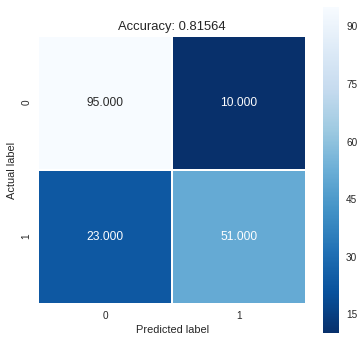

In [0]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb_prediction = gnb.predict(x_test)

score = metrics.accuracy_score(y_test, gnb_prediction)
display_confusion_matrix(y_test, gnb_prediction, score=score)

This looks okay - we have a decently high score for both True squares, although our False Negatives would ideally be lower and our True Positives would ideally be higher. Next, we will try a multi-layer perceptron model.

,precision,recall,f1-score,support
0,0.86,0.94,0.90,105
1,0.91,0.78,0.84,74
macro avg,0.88,0.86,0.87,179
micro avg,0.88,0.88,0.88,179
weighted avg,0.88,0.88,0.88,179


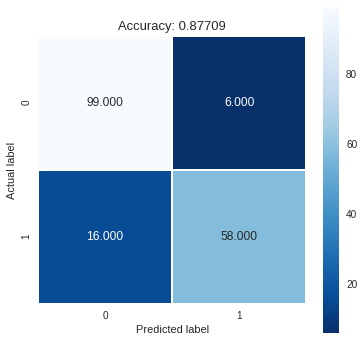

In [0]:
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_prediction = mlp.predict(x_test)

score = metrics.accuracy_score(y_test, mlp_prediction)
display_confusion_matrix(y_test, mlp_prediction, score=score)

From the generated confusion matrices, it appears that the MLP model is outperforming our Naive Bayes model by a significant margin, so we will submit the MLP classifier. The MLP classifier's True scores are higher and its False scores, especially for False Positives, are much lower than Naive Bayes.

In [0]:
test_raw = pd.read_csv(testing_set)
test = test_raw.copy()
test = preprocess(test)
test = pd.DataFrame(scale.fit_transform(test.values), index=test.index, columns=test.columns)
test.head(20)


,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,HasCabin,Title,AgeGroup,FamilySize,TicketSurvivor,Child,Alone
0,0.873482,-0.755929,-0.499470,-0.400248,-0.497185,-0.150580,2.243165,-0.527530,-0.745470,0.216878,-0.715718,-0.3253,-0.660626,0.807573
1,0.873482,1.322876,0.616992,-0.400248,-0.512048,-0.150580,-0.677841,-0.527530,0.237516,0.991705,0.368232,-0.3253,-0.660626,-1.238278
2,-0.315819,-0.755929,-0.499470,-0.400248,-0.463874,-0.150580,2.243165,-0.527530,-0.745470,1.766533,-0.715718,-0.3253,-0.660626,0.807573
3,0.873482,-0.755929,-0.499470,-0.400248,-0.482248,-0.150580,-0.677841,-0.527530,-0.745470,0.216878,-0.715718,-0.3253,-0.660626,0.807573
4,0.873482,1.322876,0.616992,0.619896,-0.417269,-0.150580,-0.677841,-0.527530,0.237516,-0.557950,1.452181,-0.3253,-0.660626,-1.238278
5,0.873482,-0.755929,-0.499470,-0.400248,-0.472165,-0.150580,-0.677841,-0.527530,-0.745470,-1.332778,-0.715718,-0.3253,1.513717,0.807573
6,0.873482,1.322876,-0.499470,-0.400248,-0.500770,-0.150580,2.243165,-0.527530,1.220501,0.216878,-0.715718,-0.3253,-0.660626,0.807573
7,-0.315819,-0.755929,0.616992,0.619896,-0.117696,-0.150580,-0.677841,-0.527530,-0.745470,0.216878,1.452181,-0.3253,-0.660626,-1.238278
8,0.873482,1.322876,-0.499470,-0.400248,-0.507940,-0.150580,0.782662,-0.527530,0.237516,-1.332778,-0.715718,-0.3253,-0.660626,0.807573
9,0.873482,-0.755929,1.733455,-0.400248,-0.204633,-0.150580,-0.677841,-0.527530,-0.745470,-0.557950,1.452181,-0.3253,-0.660626,-1.238278


In [0]:
# Using the MLP classifier:
model_test = MLPClassifier()
model_test.fit(x,y)

prediction = model_test.predict(test)

result = test_raw.copy()
result['Survived'] = prediction
result.to_csv('/content/mlp_submission_final.csv', columns=['PassengerId', 'Survived'], index=False)


After submitting on Kaggle, this prediction received a score of <b>0.78947</b> and placed <b>#3021</b>. We experimented with different activation functions for the MLP classifier, and it should be noted that the best performance was found using the relu activation function. 

We attempted to build more features around the Ticket data, such as the first digit of the Ticket number and the length of the Ticket number, but found that it actually reduced the performance of both models significantly.

This model could likely be improved through more focused feature engineering on Age and more specific analyses on family-building (finding extended families, family members who did not actually board the boat, etc.) and using different classifiers like Random Forest or a custom classifier.